<a href="https://colab.research.google.com/github/pongpatapee/NN_from_scratch/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Neural Network from scratch

Using Andrew ng's Neural Network course as reference


## Steps
1. Initialize random parameters
2. Feed Forward
  - Make prediction with the network
  - After the activation in each layer cache {W, b, Z}
3. Compute Loss
4. Backprop
  - Using the cache from the previous step compute `dA[l] and dZ[l]`
  - Cache `W[l] and b[l]` for each layer
5. Update weights using cache from previous step
  


In [27]:
import numpy as np
import h5py
import copy
import random
import matplotlib.pyplot as plt

In [28]:
from public_tests import *

In [47]:
def initialize_parameters(layer_dims):
  # layer_dims: (nx, n1, n2, ..., nL)
  np.random.seed(1)
  L = len(layer_dims)
  parameters = {}

  for l in range(1, L):
    # parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
    parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l-1])
    parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))

    assert(parameters[f"W{l}"].shape == (layer_dims[l], layer_dims[l - 1]))
    assert(parameters[f"b{l}"].shape == (layer_dims[l], 1))


  return parameters

In [48]:
def relu(Z):
  A = np.maximum(Z, 0)
  cache = Z

  assert A.shape == Z.shape

  return A, cache

def sigmoid(Z):
  cache = Z
  return (1 / (1 + np.exp(-Z))), cache


def forwardprop(X, parameters):
  # X (features, examples)

  # parameters consits of W, b for each layer, so num Layers is len/2
  L = len(parameters) // 2
  caches = []

  # linear cache = (A_prev, W, b) of each layer
  # activation cache = Z
  # cache = (linear cache, activation cache) = ((A_prev, W, b), Z)

  A_prev = X

  for l in range(1, L):
    W = parameters[f"W{l}"]
    b = parameters[f"b{l}"]

    linear_cache = (A_prev, W, b)

    Z = W @ A_prev + b
    A, activation_cache = relu(Z)


    A_prev = A

    caches.append((linear_cache, activation_cache))

  WL, bL = parameters[f"W{L}"], parameters[f"b{L}"]
  linear_cache = (A_prev, WL, bL)

  Z = WL @ A_prev + bL
  AL, activation_cache = sigmoid(Z)

  caches.append((linear_cache, activation_cache))

  return AL, caches


In [49]:
# testing forward prop
L_model_forward_test(forwardprop)

 All tests passed.


In [50]:
def compute_cost(A, Y):
  m = Y.shape[1]
  cost = (-1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1-A))
  cost = np.squeeze(cost)
  return cost

In [51]:
compute_cost_test(compute_cost)

 All tests passed.


In [52]:
def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)

  # When z <= 0, dz should be 0 as well
  dZ[Z <= 0] = 0

  assert (dZ.shape == Z.shape)

  return dZ

def sigmoid_backward(dA, cache):
  Z = cache

  s = 1/(1+np.exp(-Z))
  dZ = dA * s * (1-s) # derived from the sigmoid derivative

  assert (dZ.shape == Z.shape)

  return dZ

def linear_backward(dZ, linear_cache):
  A_prev, W, b = linear_cache
  m = A_prev.shape[1]

  # derivatives derived through calculus
  dW = (1/m) * (dZ @ A_prev.T)
  db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
  dA_prev = W.T @ dZ

  return dA_prev, dW, db

def backprop(AL, Y, caches):
  grads = {}
  L = len(caches)
  m = AL.shape[1]
  Y = Y.reshape(AL.shape)

  # from derivative of cross entropy loss - (y/a + (1-y)/(1-a))
  # already derivative with respect to loss/cost
  dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))

  current_cache = caches[L - 1]
  linear_cache, activation_cache = current_cache

  dZ = sigmoid_backward(dAL, activation_cache)
  dA_prev_temp, dW_temp, db_temp = linear_backward(dZ, linear_cache)

  grads[f"dA{L - 1}"] = dA_prev_temp
  grads[f"dW{L}"] = dW_temp
  grads[f"db{L}"] = db_temp

  # loops from L -2 -> 0
  for l in reversed(range(L - 1)):
    current_cache = caches[l]
    linear_cache, activation_cache = current_cache

    dZ = relu_backward(dA_prev_temp, activation_cache)
    dA_prev_temp, dW_temp, db_temp = linear_backward(dZ, linear_cache)

    grads[f"dA{l}"] = dA_prev_temp
    grads[f"dW{l + 1}"] = dW_temp
    grads[f"db{l+ 1}"] = db_temp


  return grads

In [53]:
L_model_backward_test(backprop)

 All tests passed.


In [54]:
def update_parameters(params, grads, learning_rate):
  L = len(params) // 2
  parameters = copy.deepcopy(params)

  for l in range(L):
    parameters[f"W{l+1}"] -= grads[f"dW{l+1}"] * learning_rate
    parameters[f"b{l+1}"] -= grads[f"db{l+1}"] * learning_rate

  return parameters

In [55]:
update_parameters_test(update_parameters)

 All tests passed.


In [56]:
def L_layer_model(X, Y, layer_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
  # np.random.seed(1) # for consistency
  costs = []

  parameters = initialize_parameters(layer_dims)


  for i in range(num_iterations):
    AL, caches = forwardprop(X, parameters) #caches[l] = ((A_prev, W, b), Z)

    cost = compute_cost(AL, Y)

    grads = backprop(AL, Y, caches)

    parameters = update_parameters(parameters, grads, learning_rate)

    if i % 100 == 0 or i == num_iterations:
      costs.append(cost)
      if print_cost:
        print(f"Iteration {i}, cost: {np.squeeze(cost)}")


  return parameters, costs



In [57]:
parameters, costs = L_layer_model(train_x, train_y, layer_dims, num_iterations=3, print_cost=False)
# print(parameters)

L_layer_model_test(L_layer_model)

Error: Datatype mismatch. in variable 0. Got type: <class 'numpy.float64'>  but expected type <class 'numpy.ndarray'>
 3  Tests passed
 1  Tests failed


AssertionError: ignored

In [58]:
# Load data function from util file
def load_data():
  train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [59]:
# loading and showing example data
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1


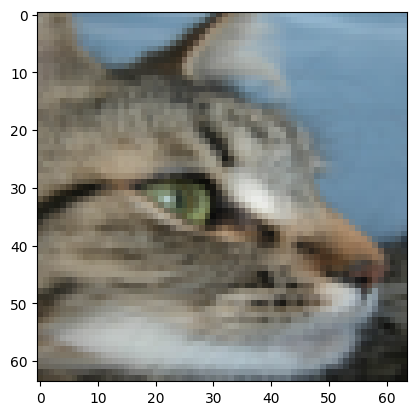

In [60]:
# preview data
index = random.randrange(0, len(train_x_orig))
plt.imshow(train_x_orig[index])
print(f"y = {str(train_y[0, index])}")

In [61]:
# print shapes
print(f"train_x_orig shape: {train_x_orig.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"test_x_orig shape: {test_x_orig.shape}")
print(f"test_y shape: {test_y.shape}")

train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [62]:
# Flatten pixels and rgb
# .shape[0] = current index for num training examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# transpose such that num training examples are stacked column wise
train_x_flatten = train_x_flatten.T
test_x_flatten = test_x_flatten.T

# standardize/normalize data to have feature values between 0 and 1
train_x = train_x_flatten/255
test_x = test_x_flatten/255

# display new shapes
print(f"train_x shape: {train_x.shape}")
print(f"test_x shape: {test_x.shape}")

train_x shape: (12288, 209)
test_x shape: (12288, 50)


In [63]:
def plot_costs(costs, learning_rate=0.0075):
  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per hundreds)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

In [64]:
def predict(X, Y, parameters):
  m = X.shape[1]
  pred, caches = forwardprop(X, parameters)
  p = np.zeros((1, m))

  for i in range(0, pred.shape[1]):
    if pred[0, i] > 0.5:
      p[0, i] = 1
    else:
      p[0, i] = 0

  print(f"Accuracy: {np.sum((p == Y) / m)}")

  return p


Iteration 0, cost: 0.7717493284237686
Iteration 100, cost: 0.6720534400822913
Iteration 200, cost: 0.6482632048575212
Iteration 300, cost: 0.6115068816101354
Iteration 400, cost: 0.567047326836611
Iteration 500, cost: 0.5401376634547801
Iteration 600, cost: 0.5279299569455267
Iteration 700, cost: 0.46547737717668514
Iteration 800, cost: 0.369125852495928
Iteration 900, cost: 0.3917469743480534
Iteration 1000, cost: 0.3151869888600617
Iteration 1100, cost: 0.2726998441789385
Iteration 1200, cost: 0.23741853400268137
Iteration 1300, cost: 0.19960120532208644
Iteration 1400, cost: 0.18926300388463305
Iteration 1500, cost: 0.16118854665827753
Iteration 1600, cost: 0.14821389662363316
Iteration 1700, cost: 0.13777487812972944
Iteration 1800, cost: 0.1297401754919012
Iteration 1900, cost: 0.12122535068005212
Iteration 2000, cost: 0.1138206066863371
Iteration 2100, cost: 0.10783928526254133
Iteration 2200, cost: 0.1028546606935268
Iteration 2300, cost: 0.10089745445261786
Iteration 2400, cost

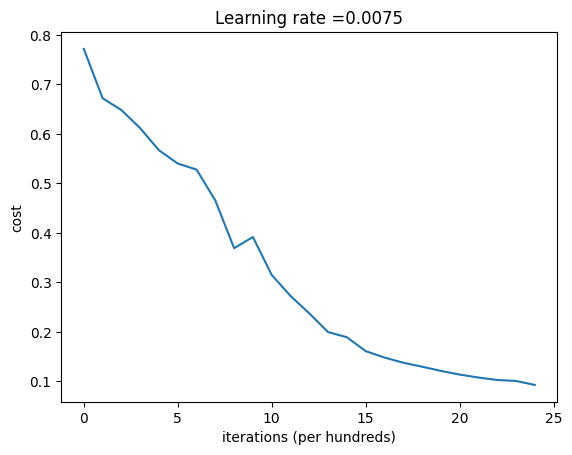

In [65]:
# feed into model
layer_dims = [12288, 20, 7, 5, 1]

parameters, costs = L_layer_model(train_x, train_y, layer_dims, num_iterations=2500, print_cost=True)
plot_costs(costs)

In [66]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [67]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8
